<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/Digits_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Connect to google drive**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/My Drive/Project/multimodal_social_media

**Library and load dataset**

In [6]:
from dataclasses import dataclass
import dataclasses
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import statistics
from tqdm import tqdm
import scipy

from sklearn.datasets import load_digits
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import Image
import cv2
from scipy.stats import entropy

**Crisis MMD dataset**

In [7]:
pd.options.display.max_colwidth = 100
file_name = "data/task_data/task_informative_text_img_agreed_lab_test.tsv"
df = pd.read_csv(file_name, sep='\t', nrows=1000)

label_cat = {"label_image":{"informative":1,"not_informative":0}}
df.label_image = pd.Categorical(df.label_image)
df['label_image_code'] = df.label_image.cat.codes

df[['image','label_image','label_image_code']]


img_arr = []
for index,row in df.iterrows():
  tmp = cv2.imread(row['image'],0)
  new_tmp = cv2.resize(tmp,(255,255))
  img_arr_tmp = new_tmp.ravel()
  tmp2 = np.array(img_arr_tmp)
  img_arr.append(tmp2)

converted_img_arr = np.array(img_arr)

In [8]:
X = converted_img_arr
y = df['label_image_code'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**Digits dataset**

In [54]:
digits = load_digits()

# array to save number of instance and accuracy result
instance_number = []
accuracy_result = []

# flatten into 1d array
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
Y = digits.target

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

**Function**

In [9]:
# data_points 30,...,390
data_points=range(30,400,10)

# train a classifier and predict
def train_and_predict(n_instances, X_train, y_train, X_test):
    clf = RandomForestClassifier()
    
    dataset_size = len(X_train)
    potential_candidates = list(range(dataset_size))
    train_indexes = np.array(random.sample(potential_candidates, n_instances))
    clf.fit(X_train[train_indexes], y_train[train_indexes])
    predicted = clf.predict(X_test)
    return predicted

def random_selection_learning(n_instances, X_train, y_train):
    clf = RandomForestClassifier()
    X_selected, X_not_selected, y_selected, y_not_selected = \
        train_test_split(X_train, y_train, train_size=n_instances, shuffle=True)
    clf.fit(X_selected, y_selected)
    return clf, X_selected, X_not_selected, y_selected, y_not_selected

In [26]:
def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    return accuracy

@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

def uncertainty_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    y_proba = model.predict_proba(X_remaining)
    uncertainty = 1. - np.max(y_proba, axis=1)
   
    ordered_positions = uncertainty.argsort()
    selected = ordered_positions[-n_new_samples:]
    non_selected = ordered_positions[:-n_new_samples]

 
    return X_remaining[selected], X_remaining[non_selected], y_remaining[selected], y_remaining[non_selected]

def learning_curve(data_points, repeats, selection_policy):
    experiments = []
    for i in tqdm(range(repeats)):
        #np.random.seed(123+i)
        # First learn 
        n_samples = data_points[0]
      
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train)
        acc = evaluate(model, X_test, y_test)
        experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
            
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
          
            model.fit(X_selected, y_selected)
            acc = evaluate(model, X_test, y_test)
            experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
            
    return experiments

experiments_uncertainty = learning_curve(data_points, 2, uncertainty_sampling_policy)
experiments_random = learning_curve(data_points, 2, random_sampling_policy)
print(experiments_uncertainty)
print(experiments_random)

100%|██████████| 2/2 [03:00<00:00, 90.48s/it]

[Experiment(n_samples=30, repeat=0, accuracy=0.64), Experiment(n_samples=40, repeat=0, accuracy=0.644), Experiment(n_samples=50, repeat=0, accuracy=0.648), Experiment(n_samples=60, repeat=0, accuracy=0.66), Experiment(n_samples=70, repeat=0, accuracy=0.672), Experiment(n_samples=80, repeat=0, accuracy=0.68), Experiment(n_samples=90, repeat=0, accuracy=0.688), Experiment(n_samples=100, repeat=0, accuracy=0.676), Experiment(n_samples=110, repeat=0, accuracy=0.672), Experiment(n_samples=120, repeat=0, accuracy=0.68), Experiment(n_samples=130, repeat=0, accuracy=0.684), Experiment(n_samples=140, repeat=0, accuracy=0.704), Experiment(n_samples=150, repeat=0, accuracy=0.684), Experiment(n_samples=160, repeat=0, accuracy=0.692), Experiment(n_samples=170, repeat=0, accuracy=0.688), Experiment(n_samples=180, repeat=0, accuracy=0.68), Experiment(n_samples=190, repeat=0, accuracy=0.688), Experiment(n_samples=200, repeat=0, accuracy=0.672), Experiment(n_samples=210, repeat=0, accuracy=0.672), Expe

In [27]:
def plot_learning_curve(df, name):
  
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Learning curve for classifier '+name)
        plt.plot(training_sizes, p50, label=name, marker='o')

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,alpha=0.1)

    plt.legend(loc='lower right')
    plt.xlabel("N sample")
    plt.ylabel("Accuracy")
    plt.grid()

**Plot learning curve**

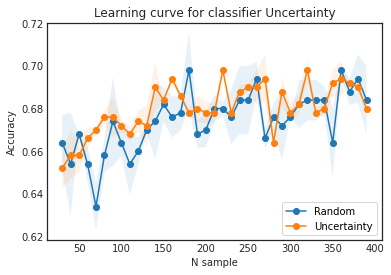

In [28]:
df_random = pd.DataFrame([dataclasses.asdict(e) for e in experiments_random])
df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiments_uncertainty])

plot_learning_curve(df_random, "Random")
plot_learning_curve(df_us, "Uncertainty")